# Stage 4: Creating neural networks

前面我们主要处理的变量是标量，但在机器学习领域，张量(多维数组)扮演着重要的角色。  
这一阶段的目标是将 DeZero 扩展到机器学习，尤其是神经网络领域。

In [1]:
import numpy as np
import dezero.functions as F
from dezero import Variable
import matplotlib.pyplot as plt

## Step 37: Processing tensors

前面，我们处理的变量主要是标量。本步骤将将讨论使用张量时需要注意的地方，并为扩展DeZero做准备。

In [3]:
x = Variable(np.array(1.0))
y = F.sin(x)
print(y)

variable(0.8414709848078965)


In [5]:
# 会对多维数组进行逐元素运算，不改变形状
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sin(x)
print(y)
# 逐元素相加
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
y = x + c
print(y)

variable([[ 0.84147098  0.90929743  0.14112001]
          [-0.7568025  -0.95892427 -0.2794155 ]])
variable([[11 22 33]
          [44 55 66]])


在使用当前己实现函数的情况下，即使对张量进行计算，反向传播的代码也能
正常工作：
1. 以标量为对象实现了反向传播
2. 向目前实现的 DeZero 函数传入张量，函数会将每个张量的元素作为标量进行计算
3. 如果将张量的每个元素作为标量进行计算，那么以标量为前提实现的
反向传播也会对张量的每个元素进行计算

$\mathbf{y} = F(\mathbf{x})$向量求导（雅可比矩阵）：
$$
\begin{align*}
\frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \left(
\begin{array}{ccc}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \cdots & \frac{\partial y_1}{\partial x_n} \\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \cdots & \frac{\partial y_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial y_m}{\partial x_1} & \frac{\partial y_m}{\partial x_2} & \cdots & \frac{\partial y_m}{\partial x_n}
\end{array}
\right)
\end{align*}
$$
如果$\mathbf{y}$是标量，那么就只有一行$\left(\frac{\partial y}{\partial x_1}, \frac{\partial y}{\partial x_2}, \cdots, \frac{\partial y}{\partial x_n}\right)$。

接下来考虑复合函数，基于链式法则，可以得到：
$$
\begin{align*}
\frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \frac{\partial \mathbf{y}}{\partial \mathbf{a}} \frac{\partial \mathbf{a}}{\partial \mathbf{b}} \frac{\partial \mathbf{b}}{\partial \mathbf{x}}
\end{align*}
$$
计算通过矩阵乘法实现。


## Step 38: Function for changing shape

现在要看不逐元素进行运算的函数-reshape、transpose等。

reshape函数只是对形状进行变换，不进行具体的计算。因此在反向传播时，只需将梯度转换为原始形状传递给上游即可。


In [2]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.reshape(x, (6,))
y.backward(retain_grad=True)
print(y.grad)
print(x.grad)

variable([1 1 1 1 1 1])
variable([[1 1 1]
          [1 1 1]])


numpy的ndarray实例可以直接使用reshape方法，为了让函数更易用，在Variable类中实现reshape方法。

In [2]:
x = Variable(np.random.randn(1,2,3))
print(x)
y = x.reshape((2,3))
print(y)
y = x.reshape(2,3)
print(y)

variable([[[-1.25690037  0.1060291   0.75893363]
           [-0.64814541  0.06557808  1.41735456]]])
variable([[-1.25690037  0.1060291   0.75893363]
          [-0.64814541  0.06557808  1.41735456]])
variable([[-1.25690037  0.1060291   0.75893363]
          [-0.64814541  0.06557808  1.41735456]])


transpose转置函数与reshape函数实现方式类似，只需将形状变换即可。

In [3]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = x.transpose()
print(y)
y = x.T
print(y)
y.backward(retain_grad=True)
print(y.grad)
print(x.grad)

variable([[1 4]
          [2 5]
          [3 6]])
variable([[1 4]
          [2 5]
          [3 6]])
variable([[1 1]
          [1 1]
          [1 1]])
variable([[1 1 1]
          [1 1 1]])


## Step 39: Funciton for summing elements

之前实现的加法函数反向传播时，将梯度直接传递给两个输入变量。

现在实现的函数对张量的元素进行求和也同理，反向传播时，将梯度传递给所有元素，即按向量元素数量复制梯度。

而复制操作也是操作Variable类的方法，需要实现broadcast_to方法。

另外np的sum函数可以指定axis参数，实现对指定轴求和，这里也要实现这个功能。

In [3]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

x.cleargrad()
y = x.sum(axis=0)
y.backward()
print(y)
print(x.grad)

x = Variable(np.random.randn(2,3,4,5))
y = x.sum(keepdims=True)
print(y.shape)

variable(21)
variable([[1 1 1]
          [1 1 1]])
variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])
(1, 1, 1, 1)


## Step 40: Function for broadcasting

y = x + x可以理解为复制x后再相加，在反向传播时，需要将梯度累加到x上。

广播操作也是类似原理，在反向传播时，需要将梯度累加到原始形状上。

这里需要使用sum_to函数，进行求和并将形状变换回去。

而sum_to函数的反向传播实现是将梯度复制到原始形状上，则使用broadcast_to函数。

另外，np中的广播操作往往是幕后进行的，所以需要拓展原来的四则运算函数，使其支持广播操作。

In [2]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

y.backward()
print(x1)
print(x1.grad)

variable([11 12 13])
variable([10])
variable([3])


## Step 41: Product of matrices

向量内积：
$$
\begin{align*}
\mathbf{y} = \mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^{n} a_i b_i
\end{align*}
$$
矩阵乘法：
$$
\begin{align*}
\mathbf{Y} = \mathbf{A} \mathbf{B} = \left(
\begin{array}{ccc}
\sum_{i=1}^{n} a_{1i} b_{i1} & \sum_{i=1}^{n} a_{1i} b_{i2} & \cdots & \sum_{i=1}^{n} a_{1i} b_{im} \\
\sum_{i=1}^{n} a_{2i} b_{i1} & \sum_{i=1}^{n} a_{2i} b_{i2} & \cdots & \sum_{i=1}^{n} a_{2i} b_{im} \\
\vdots & \vdots & \ddots & \vdots \\
\sum_{i=1}^{n} a_{mi} b_{i1} & \sum_{i=1}^{n} a_{mi} b_{i2} & \cdots & \sum_{i=1}^{n} a_{mi} b_{im}
\end{array}
\right)
\end{align*}
$$

都使用np.dot函数实现，如果两个参数都是一维数组，则是向量内积；如果两个参数都是二维数组，则是矩阵乘法。

<center>
<table>
  <tr>
    <td><img src="./res/matmul_easy.png" width="400"/></td>
  </tr>
</table>
</center>

对于反向传播，首先考虑简单情况 $y = xW$，其中x为1×D的向量，W为D×H的矩阵，y为1×H的向量。
$$
\begin{align*}
\frac{\partial L}{\partial x_i} = \sum_{j=1}^{H} \frac{\partial L}{\partial y_j} \frac{\partial y_j}{\partial x_i} = \sum_{j=1}^{H} \frac{\partial L}{\partial y_j} W_{ij}
\end{align*}
$$
其中，$W_{ij}$表示W的第i行第j列元素。

当$x_i$发生变化时，向量$y$的所有元素都会发生变化。$y$的每个元素改变也会使$L$发生变化，因此从$x_i$到$L$有多条链式法则的路径。

由前可知，$\frac{\partial L}{\partial x_i}$可通过向量$\frac{\partial L}{\partial y}$和矩阵$W$的第i行向量的内积得到，因此可以推广得到：
$$
\begin{align*}
\frac{\partial L}{\partial \mathbf{x}} = \frac{\partial L}{\partial \mathbf{y}} \mathbf{W}^T
\end{align*}
$$

<center>
<table>
  <tr>
    <td><img src="./res/matmul_complex.png" width="400"/></td>
    <td><img src="./res/matmul_grad.png" width="350"/></td>
  </tr>
</table>
</center>

In [2]:
x = Variable(np.random.randn(2,3))
W = Variable(np.random.randn(3,4))
y = F.matmul(x, W)
y.backward()

print(x)
print(x.grad.shape)
print(W)
print(W.grad.shape)

variable([[-0.2218563  -1.86013392  0.04561382]
          [ 0.44896001  1.74007878  0.41856793]])
(2, 3)
variable([[-1.74508997  0.53697346  0.04406799  0.73966956]
          [ 0.88525435 -1.52196217  0.1616612   0.8558494 ]
          [ 1.04271278  0.30658378 -1.54890008  0.21894359]])
(3, 4)


## Step 42: Linear regression

机器学习的本质就是从数据中寻找解决方案。

线性回归的目标是找到一条拟合数据的直线$y = Wx + b$，使以下损失函数最小：
$$
\begin{align*}
L = \frac{1}{N} \sum_{i=1}^{N} (y_i - (Wx_i + b))^2
\end{align*}
$$

In [9]:
# toy dataset
np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)

In [10]:
x, y = Variable(x), Variable(y)
W = Variable(np.zeros((1, 1))) # (100,1) * (1,1) = (100,1)
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x, W) + b
    return y

In [11]:
def mean_squared_error(x0, x1):  # 会引入中间变量，封装成function内存更优
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    # Update .data attribute (No need grads when updating params)
    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    if i % 10 == 0:
        print(W, b, loss)

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[2.425382]]) variable([5.02561369]) variable(0.24915731977561134)
variable([[2.45731071]]) variable([5.27768752]) variable(0.10078974954301652)
variable([[2.39696452]]) variable([5.3238]) variable(0.09461859803040694)
variable([[2.33913091]]) variable([5.35400772]) variable(0.0902667138137311)
variable([[2.28830557]]) variable([5.37981674]) variable(0.08694585483964615)
variable([[2.24388206]]) variable([5.40233244]) variable(0.08441084206493275)
variable([[2.20506799]]) variable([5.42200258]) variable(0.08247571022229121)
variable([[2.17115586]]) variable([5.43918838]) variable(0.08099850454041051)
variable([[2.14152662]]) variable([5.45420371]) variable(0.07987086218625004)


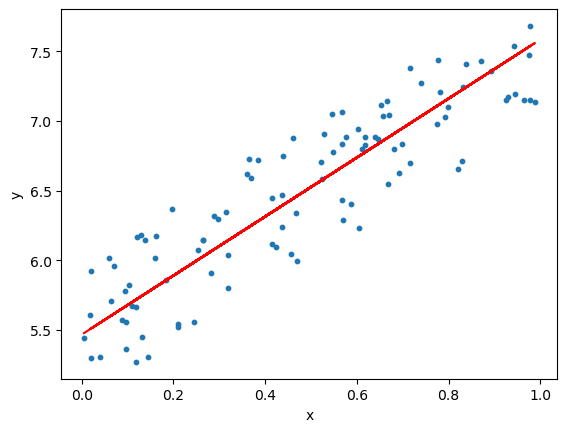

In [12]:
# Plot
plt.scatter(x.data, y.data, s=10)
plt.xlabel('x')
plt.ylabel('y')
y_pred = predict(x)
plt.plot(x.data, y_pred.data, color='r')
plt.show()

# Step 43: Neural networks

前面实现了线性变化，实现中使用了matmul和add函数。会出现一个问题，在计算图存在期间，Variable实例的数据会一直保持在内存中，这会导致内存占用过大。

如果将其封装为一个Linear类，中间结果**没有作为Variable实例存储**，数据在正向传播结束后就会被释放。
<center>
<table>
  <tr>
    <td><img src="./res/linear.png" width="400"/></td>
  </tr>
</table>
</center>

如左上图，+的反向传播仅仅传播输出端的梯度。也就是说，+的反向传播小不需要t的数据。另外，matmul的反向传播只需要输入变量x、W和b，也不需要t的数据。

当然可以通过手动删除中间结果的方式来减少内存占用，但这样会增加代码的复杂度。通过定义Linear类在反向传播时执行+和matmul的反向传播，更加方便。


In [2]:
def linear_simple(x, W, b=None):
    t = F.matmul(x, W)
    if b is None:
        return t
    y = t + b
    t.data = None  # Release t.data (ndarray) for memory efficiency
    return y

下面创建一个非线性数据集，此时不能再用线性回归来处理，需要使用神经网络。

神经网络对线性变化的输出进行非线性变换(激活函数)，典型的激活函数有ReLU、Sigmoid、Tanh等。

In [3]:
# 非线性数据集
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

In [4]:
def sigmoid_simple(x):
    x = F.as_variable(x)
    y = 1 / (1 + F.exp(-x))
    return y

In [7]:
# 权重初始化
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

# 神经网络
def predict(x):
    y = linear_simple(x, W1, b1)
    y = sigmoid_simple(y)
    y = linear_simple(y, W2, b2)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0:
        print(loss)

variable(0.8497718314877383)
variable(0.2511875064699415)
variable(0.24788481609580212)
variable(0.24350143977748862)
variable(0.23530660980273407)
variable(0.2166019337094654)
variable(0.15967767407669228)
variable(0.08797255787796882)
variable(0.07751013470972867)
variable(0.07692128879681837)


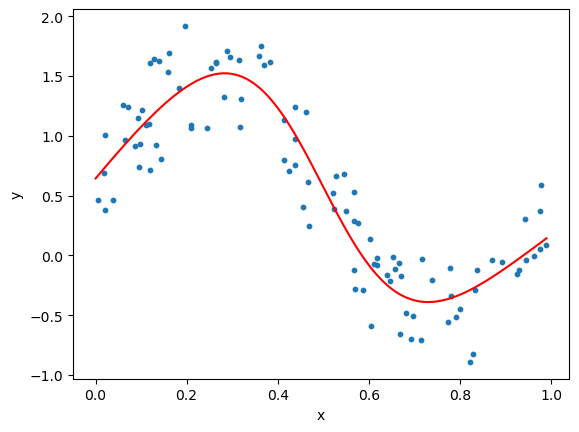

In [8]:
# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()